## Stock Data of Amazon, Apple, Google, Microsoft is collected from 2013 to 2018 . Technical Indicators are calculated using Adj Close .

In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline

In [3]:
# taking extra days to calculate technical indicators 
start = '2012-12-12'
end = '2018-12-31' 

train_start = '2013-01-01'
test_start = '2017-01-01'


In [4]:
companies = {'Amazon': 'AMZN', 
             'Apple' : 'APPL',
             'Google': 'GOOG',
             'Microsoft': 'MSFT'}

In [5]:
# Getting stock data from Yahoo API using pandas_datareader
Amazon = data.DataReader('AMZN','yahoo', start, end)
Apple  = data.DataReader('AAPl','yahoo', start, end)
Google = data.DataReader('GOOG','yahoo', start, end)
Microsoft = data.DataReader('MSFT','yahoo', start, end)

In [6]:
dfList = list([Amazon, Apple, Google, Microsoft])
companyNames = list(['Amazon', 'Apple', 'Google', 'Microsoft'])

In [7]:
Amazon.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-12-11,253.479996,246.649994,248.500000,250.690002,4185200,250.690002
2012-12-12,254.360001,250.059998,251.070007,251.759995,2628100,251.759995
2012-12-13,254.539993,250.020004,251.110001,251.250000,2460200,251.250000
2012-12-14,251.899994,247.789993,250.110001,249.190002,2526900,249.190002
2012-12-17,254.000000,249.259995,249.809998,253.860001,2277000,253.860001


In [8]:
Amazon.shape

(1524, 6)

In [9]:
# training data 
len(Amazon[:test_start])

1022

In [10]:
# Checking for Null Values 
for i in range(len(dfList)):
    print("Company {}".format(companyNames[i]))
    for col in dfList[i].columns:
        print('{}:{}'.format(col, dfList[i][col].isnull().sum()))
    print('____________________________________________')
    

Company Amazon
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
____________________________________________
Company Apple
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
____________________________________________
Company Google
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
____________________________________________
Company Microsoft
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
____________________________________________


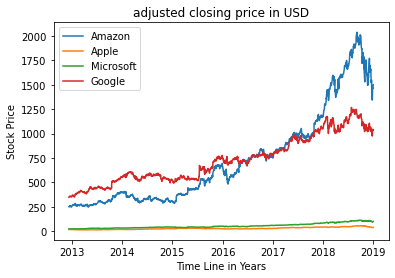

In [11]:
# plotting the closing price of all the considered companies 
plt.title('adjusted closing price in USD')
plt.plot(Amazon['Adj Close'], label = 'Amazon')
plt.plot(Apple['Adj Close'], label = 'Apple')
plt.plot(Microsoft['Adj Close'], label = 'Microsoft')
plt.plot(Google['Adj Close'], label = 'Google')
plt.xlabel('Time Line in Years')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Feature Engineering 

####  -> Simple Moving Average (15 days)
https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/sma

In [12]:
# Calculating SMA for a window of 15 days
days = 15
Amazon['SMA'] = Amazon['Adj Close'].rolling(window = days).mean()
Apple['SMA'] = Apple['Adj Close'].rolling(window = days).mean()
Google['SMA'] = Google['Adj Close'].rolling(window = days).mean()
Microsoft['SMA'] = Microsoft['Adj Close'].rolling(window = days).mean()

#### -> Moving Average Convergence and Divergence
https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/macd

https://towardsdatascience.com/implementing-macd-in-python-cc9b2280126a

In [13]:
def MACD(df):
    exp1 = df['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Adj Close'].ewm(span=26, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=9, adjust=False).mean()
    return exp3

In [14]:
Amazon['MACD'] = MACD(Amazon)
Apple['MACD']  = MACD(Apple)
Google['MACD'] = MACD(Google)
Microsoft['MACD'] = MACD(Microsoft)

#### -> Stochastic K and Stochastic D
https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/slow-stochastic

https://www.investopedia.com/terms/s/stochasticoscillator.asp

https://stackoverflow.com/questions/30261541/slow-stochastic-implementation-in-python-pandas

In [15]:
def stochastic_K(df, k = 14, d = 3):
    low_min  = df['Low'].rolling( window = k ).min()
    high_max = df['High'].rolling( window = k ).max()

    # Fast Stochastic
    df['k'] = 100 * (df['Adj Close'] - low_min)/(high_max - low_min)
    
    # Slow stochastic
    df['d'] = df['k'].rolling(window = d).mean()

    return df



In [16]:
Amazon = stochastic_K(Amazon)
Apple  = stochastic_K(Apple)
Google = stochastic_K(Google)
Microsoft = stochastic_K(Microsoft)

#### -> Relative Strength Index
https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/RSI

https://tcoil.info/compute-rsi-for-stocks-with-python-relative-strength-index/


In [17]:
def computeRSI (data, time_window = 14):
    diff = data.diff(1).dropna() # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [18]:
Amazon['RSI'] = computeRSI(Amazon['Adj Close'])
Apple['RSI'] = computeRSI(Apple['Adj Close'])
Google['RSI'] = computeRSI(Google['Adj Close'])
Microsoft['RSI'] = computeRSI(Microsoft['Adj Close'])

In [19]:
# Removing the extra data from 2012
Amazon = Amazon[14:]
Apple = Apple[14:]
Google = Google[14:]
Microsoft = Microsoft[14:]

### Normalizing the data

In [20]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [21]:
Amazon = normalize(Amazon)
Apple  = normalize(Apple)
Google = normalize(Google)
Microsoft = normalize(Microsoft)

In [22]:
Amazon.head()

,High,Low,Open,Close,Volume,Adj Close,SMA,MACD,k,d,RSI
Date,,,,,,,,,,,
2013-01-02,0.002876,0.004250,0.003991,0.005069,0.095753,0.005069,0.000000,0.558157,0.715128,NaN,0.502936
2013-01-03,0.004423,0.006009,0.004656,0.005722,0.072906,0.005722,0.000302,0.558375,0.772594,0.625304,0.524830
2013-01-04,0.003822,0.006168,0.004829,0.006096,0.034395,0.006096,0.000588,0.559164,0.805501,0.766795,0.537622
2013-01-07,0.009346,0.009574,0.007842,0.011294,0.167749,0.011294,0.001255,0.561472,0.952927,0.849530,0.681949
2013-01-08,0.008929,0.010083,0.010133,0.010132,0.084318,0.010132,0.001921,0.564319,0.875834,0.885449,0.626353


In [23]:
Google.head()

,High,Low,Open,Close,Volume,Adj Close,SMA,MACD,k,d,RSI
Date,,,,,,,,,,,
2013-01-02,0.011696,0.011607,0.007992,0.011056,0.219448,0.011056,0.000000,0.528227,0.835766,NaN,0.661404
2013-01-03,0.014358,0.013908,0.010975,0.011284,0.200152,0.011284,0.001007,0.529930,0.770109,0.690830,0.665709
2013-01-04,0.019509,0.017749,0.013363,0.019042,0.238665,0.019042,0.002526,0.534374,0.923026,0.847016,0.785098
2013-01-07,0.018380,0.019350,0.016671,0.017295,0.142855,0.017295,0.003731,0.539751,0.852211,0.852750,0.721819
2013-01-08,0.016717,0.015956,0.016720,0.016508,0.144619,0.016508,0.004909,0.545123,0.820320,0.870258,0.693544


In [24]:
Apple.head()

,High,Low,Open,Close,Volume,Adj Close,SMA,MACD,k,d,RSI
Date,,,,,,,,,,,
2013-01-02,0.125862,0.127951,0.135113,0.128448,0.363698,0.109705,0.081264,0.549766,0.690233,NaN,0.586829
2013-01-03,0.121545,0.127436,0.130274,0.122832,0.217013,0.104838,0.081300,0.554656,0.661842,0.641701,0.514435
2013-01-04,0.112603,0.115036,0.121386,0.110595,0.387597,0.094235,0.080702,0.558482,0.599978,0.641489,0.383434
2013-01-07,0.105047,0.106346,0.109190,0.108083,0.309731,0.092058,0.080413,0.561117,0.587277,0.605648,0.359953
2013-01-08,0.107144,0.111292,0.115064,0.109226,0.291745,0.093048,0.081187,0.563107,0.561413,0.570687,0.372721


In [25]:
Microsoft.head()

,High,Low,Open,Close,Volume,Adj Close,SMA,MACD,k,d,RSI
Date,,,,,,,,,,,
2013-01-02,0.010958,0.009814,0.008546,0.013012,0.188685,0.010813,0.002719,0.427297,0.463515,NaN,0.520971
2013-01-03,0.010064,0.009927,0.012819,0.008861,0.169578,0.007364,0.002675,0.427497,0.424042,0.354731,0.418820
2013-01-04,0.006597,0.005076,0.008771,0.003141,0.187116,0.002610,0.002357,0.426349,0.369635,0.355924,0.304747
2013-01-07,0.001454,0.004061,0.003149,0.002580,0.123172,0.002144,0.002090,0.424262,0.364301,0.318941,0.294644
2013-01-08,0.000447,0.002030,0.002924,0.001010,0.154677,0.000839,0.001925,0.421215,0.349365,0.291105,0.265975


In [26]:
# Checking for Null Values 
for i in range(len(dfList)):
    print("Company {}".format(companyNames[i]))
    for col in dfList[i].columns:
        print('{}:{}'.format(col, dfList[i][col].isnull().sum()))
    print('____________________________________________')
    

Company Amazon
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
SMA:14
MACD:0
k:13
d:15
RSI:14
____________________________________________
Company Apple
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
SMA:14
MACD:0
k:13
d:15
RSI:14
____________________________________________
Company Google
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
SMA:14
MACD:0
k:13
d:15
RSI:14
____________________________________________
Company Microsoft
High:0
Low:0
Open:0
Close:0
Volume:0
Adj Close:0
SMA:14
MACD:0
k:13
d:15
RSI:14
____________________________________________


In [27]:
def replace_nan(df):
    df['SMA'] = df['SMA'].fillna(df['SMA'].mean())
    df['k'] = df['k'].fillna(df['k'].mean())
    df['d'] = df['d'].fillna(df['d'].mean())
    df['RSI'] = df['RSI'].fillna(df['RSI'].mean())
    return df

In [28]:
Amazon = replace_nan(Amazon)
Apple = replace_nan(Apple)
Microsoft = replace_nan(Microsoft)
Google = replace_nan(Google)

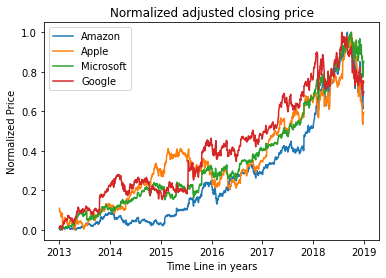

In [29]:
# Plotting the Normalized Closing Prices of all the considered companies 
plt.title('Normalized adjusted closing price')
plt.plot(Amazon['Adj Close'], label = 'Amazon')
plt.plot(Apple['Adj Close'], label = 'Apple')
plt.plot(Microsoft['Adj Close'], label = 'Microsoft')
plt.plot(Google['Adj Close'], label = 'Google')
plt.xlabel('Time Line in years')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

## Stock Price vs Market Technical Indicators

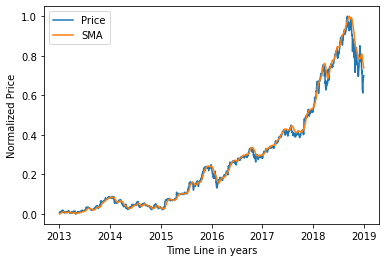

In [30]:
# Simple Moving Average
plt.plot(Amazon['Adj Close'], label = 'Price')
plt.plot(Amazon['SMA'], label = 'SMA')
plt.xlabel('Time Line in years')
plt.ylabel('Normalized Price')
plt.legend()


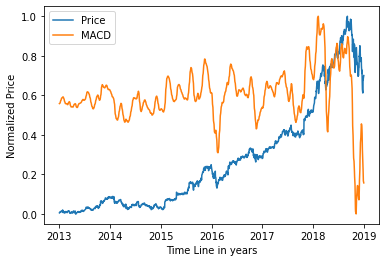

In [32]:
# Moving Average Convergence and Divergence
plt.plot(Amazon['Adj Close'], label = 'Price')
plt.plot(Amazon['MACD'], label = 'MACD')
plt.xlabel('Time Line in years')
plt.ylabel('Normalized Price')
plt.legend()

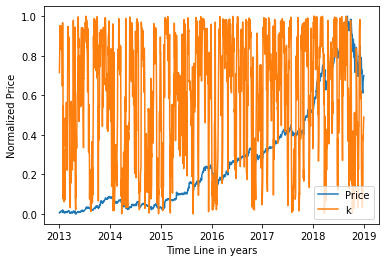

In [34]:
# Stochastic K
plt.plot(Amazon['Adj Close'], label = 'Price')
plt.plot(Amazon['k'], label = 'k')
plt.xlabel('Time Line in years')
plt.ylabel('Normalized Price')
plt.legend()

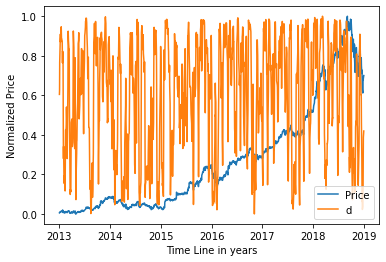

In [35]:
# Stochastic D
plt.plot(Amazon['Adj Close'], label = 'Price')
plt.plot(Amazon['d'], label = 'd')
plt.xlabel('Time Line in years')
plt.ylabel('Normalized Price')
plt.legend()

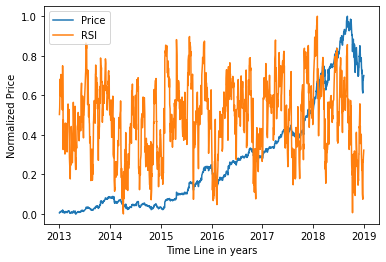

In [36]:
# Relative Strength Index
plt.plot(Amazon['Adj Close'], label = 'Price')
plt.plot(Amazon['RSI'], label = 'RSI')
plt.xlabel('Time Line in years')
plt.ylabel('Normalized Price')
plt.legend()

In [37]:
Amazon.to_csv('Amazon.csv')
Apple.to_csv('Apple.csv')
Google.to_csv("Google.csv")
Microsoft.to_csv('Microsoft.csv')